In [69]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
    f1_score,
    auc,
)
from sklearn.base import clone
from sklearn.ensemble import VotingClassifier


sns.set(style="whitegrid")
sns.set_color_codes("pastel")

In [64]:
full_train = pd.read_csv("../datasets/train_clean.csv")

to_drop = [
    "Name",
    "Ticket",
    "Embarked",
    "PassengerId",
    *[c for c in full_train if "cabin" in c.lower()],
]

full_train.drop(columns=to_drop, inplace=True)

target_col = "Survived"

X = full_train.drop(target_col, axis=1)
y = full_train[target_col]

X_train, y_train = X, y

model = DecisionTreeClassifier(
    class_weight=None,
    max_features=None,
    random_state=42,
)

param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [i for i in range(2, 12, 1)],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8],
    "min_samples_split": [i for i in range(8, 20, 1)],
}

grid_search = GridSearchCV(
    model, param_grid, n_jobs=1, cv=5, scoring="accuracy", verbose=4
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 1920 candidates, totalling 9600 fits
[CV 1/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=8;, score=0.747 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=8;, score=0.792 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=8;, score=0.787 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=8;, score=0.753 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=8;, score=0.785 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=9;, score=0.747 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=9;, score=0.792 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=9;, score=0.787 total time=   0.0s
[CV 4/5] END cr

In [71]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

top_models_indices = grid_search.cv_results_["mean_test_score"].argsort()[-10:][::-1]

top_models_params = [
    grid_search.cv_results_["params"][index] for index in top_models_indices
]

top_models = []

for params in top_models_params:
    model = clone(grid_search.best_estimator_)
    model.set_params(**params)
    model.fit(X_train, y_train)
    top_models.append((f"model_{repr(params)}", model))

ensemble_model = VotingClassifier(estimators=top_models, voting="hard")

y_train_pred = cross_val_predict(ensemble_model, X_train, y_train, cv=5)

ensemble_model.fit(X_train, y_train)

accuracy_train = accuracy_score(y_train, y_train_pred)

print(f"Ensemble Model Accuracy on Training Set: {accuracy_train}")

Ensemble Model Accuracy on Training Set: 0.8233970753655793


In [73]:
y_train_pred = cross_val_predict(grid_search.best_estimator_, X_train, y_train, cv=5)

accuracy_train = accuracy_score(y_train, y_train_pred)

print(f"Best Model Accuracy on Training Set: {accuracy_train}")

Best Model Accuracy on Training Set: 0.8278965129358831


In [65]:
res_dicts = pd.DataFrame(
    pd.DataFrame(grid_search.cv_results_)
    .sort_values(by="rank_test_score")["params"]
    .values
)[0]

In [66]:
with pd.option_context("display.max_colwidth", 200):
    print(res_dicts.iloc[:25])

0     {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 14}
1     {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 15}
2     {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 19}
3     {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 18}
4     {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 16}
5     {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 11}
6     {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 10}
7      {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 9}
8      {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 8}
9     {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 12}
10    {'criterion': 'entropy', 'max_depth': 8, 'mi

In [85]:
import joblib

joblib.dump(
    grid_search,
    f"../models/{grid_search.best_estimator_.__class__.__name__}_{grid_search.best_score_ * 100:.4f}.joblib",
)
joblib.dump(
    ensemble_model, f"../models/ensemble_{grid_search.best_score_ * 100:.4f}.joblib"
)

['../models/ensemble_82.7931.joblib']

In [75]:
model_name = grid_search.estimator.__class__.__name__

get_best = True  # get the best model or the latest model

# get files in models sorted by last modified
if get_best:
    import os
    import re

    files = os.listdir("../models")
    files = [f for f in files if re.match(f"{model_name}_.*\.joblib", f)]
    files = sorted(
        files, key=lambda x: re.search(r"_(\d+\.\d+)\.joblib", x).group(1), reverse=True
    )
    file_name = files[0]
else:
    import os
    import re

    files = os.listdir("../models")
    files = [f for f in files if re.match(f"{model_name}_.*\.joblib", f)]
    files = sorted(
        files, key=lambda x: os.path.getmtime(os.path.join("models", x)), reverse=True
    )
    file_name = files[0]
loaded_grid_search = joblib.load(f"../models/{file_name}")

In [86]:
model_name = "ensemble"

get_best = True  # get the best model or the latest model

# get files in models sorted by last modified
if get_best:
    import os
    import re

    files = os.listdir("../models")
    files = [f for f in files if re.match(f"{model_name}_.*\.joblib", f)]
    files = sorted(
        files, key=lambda x: re.search(r"_(\d+\.\d+)\.joblib", x).group(1), reverse=True
    )
    file_name = files[0]
else:
    import os
    import re

    files = os.listdir("../models")
    files = [f for f in files if re.match(f"{model_name}_.*\.joblib", f)]
    files = sorted(
        files, key=lambda x: os.path.getmtime(os.path.join("models", x)), reverse=True
    )
    file_name = files[0]
loaded_grid_search = joblib.load(f"../models/{file_name}")

In [87]:
for k, v in loaded_grid_search.cv_results_.items():
    print(k, v, sep="\t")

AttributeError: 'VotingClassifier' object has no attribute 'cv_results_'

In [88]:
real_test = pd.read_csv("../datasets/test_clean.csv")

In [89]:
real_test.drop(columns=list(set(to_drop) - {"PassengerId"}), inplace=True)

In [90]:
pred = pd.DataFrame(best_model.predict(real_test.drop(columns=["PassengerId"]))).rename(
    columns={0: "Survived"}
)

In [91]:
# get probabilities
probs = best_model.predict_proba(X_train)

# keep probabilities for the positive outcome only
probs = probs[:, 1]

# predict class values
yhat = best_model.predict(X_train)

# calculate roc-auc score
lr_auc = roc_auc_score(y_train, probs)

# calculate roc curve
ns_fpr, ns_tpr, _ = roc_curve(y_train, probs)

# get f1 score
lr_f1 = f1_score(y_train, best_model.predict(X_train))

# get auc score
lr_auc = auc(ns_fpr, ns_tpr)

# get precision & recall
lr_precision, lr_recall, _ = precision_recall_curve(y_train, probs)

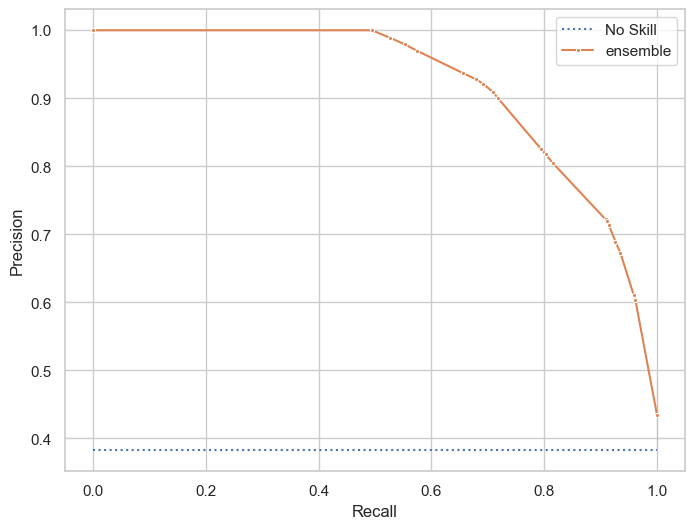

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get no-skill line
no_skill = len(y_train[y_train == 1]) / len(y_train)

# Set the style
sns.set(style="whitegrid")

# Plot the precision-recall curves
plt.figure(figsize=(8, 6))
sns.lineplot(x=[0, 1], y=[no_skill, no_skill], linestyle="dotted", label="No Skill")
sns.lineplot(x=lr_recall, y=lr_precision, marker=".", label=model_name)

# Set axis labels
plt.xlabel("Recall")
plt.ylabel("Precision")

# Show the legend
plt.legend()

# Show the plot
plt.show()

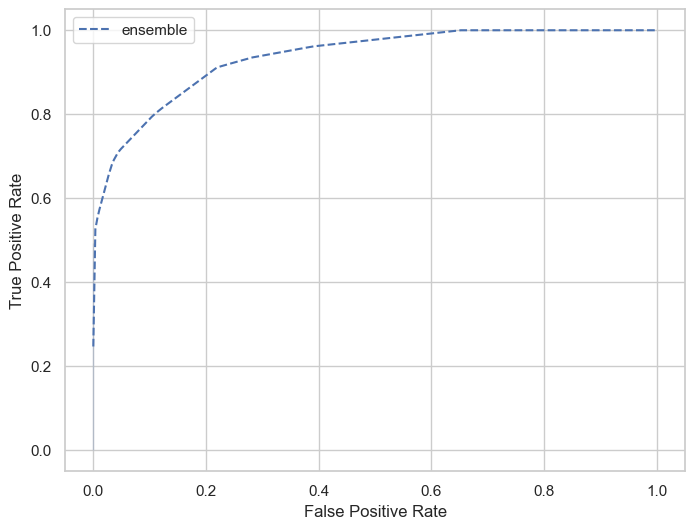

In [93]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
sns.lineplot(x=ns_fpr, y=ns_tpr, linestyle="--", label=model_name)

# Set axis labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Show the legend
plt.legend()

# Show the plot
plt.show()

In [94]:
pd.concat([real_test[["PassengerId"]], pred], axis=1).to_csv(
    f"../outs/{best_model.__class__.__name__}_{grid_search.best_score_ * 100:.4f}.csv",
    index=False,
)